# LAB 1

In [42]:
from importlib import reload
import numpy as np
import maze as mz
reload(mz)

<module 'maze' from '/mnt/F6C41197C4115AE7/Uni/Magistrale/RL/KTH-ReinforcementLearning/LAB1/EX1/maze.py'>

### Point A: Dynamic programming

In [43]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])
# with the convention
# 0 = empty cell
# 1 = obstacle
# 2 = exit of the Maze

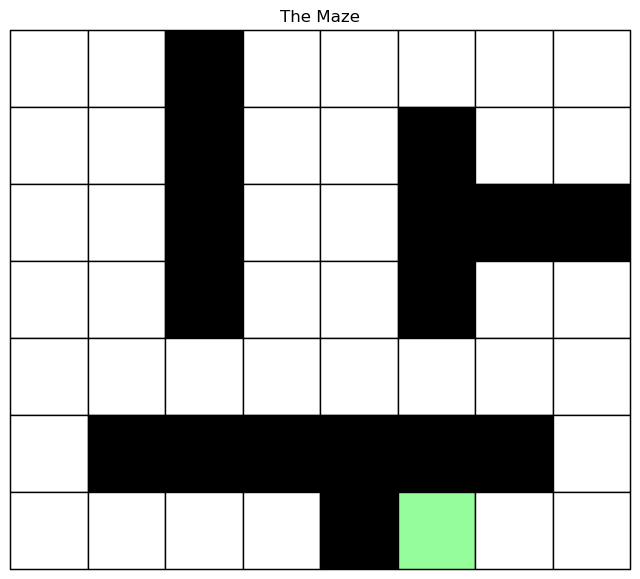

In [44]:
mz.draw_maze(maze)

In [45]:
# Create an environment maze
reload(mz)
env = mz.Maze(maze)

In [46]:
# Finite horizon
max = 20
for horizon in range(max+1):
    print("HORIZON:"+str(horizon))
    V, policy= mz.dynamic_programming(env,horizon)

HORIZON:0
HORIZON:1
HORIZON:2
HORIZON:3
HORIZON:4
HORIZON:5
HORIZON:6
HORIZON:7
HORIZON:8
HORIZON:9
HORIZON:10
HORIZON:11
HORIZON:12
HORIZON:13
HORIZON:14
HORIZON:15
HORIZON:16
HORIZON:17
HORIZON:18
HORIZON:19
HORIZON:20


In [38]:
# Finite horizon
horizon = 20
# Solve the MDP problem with dynamic programming 
V, policy = mz.dynamic_programming(env,horizon)
print(policy)

[[2. 2. 2. ... 2. 2. 0.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 3. 3.]
 [1. 1. 1. ... 1. 1. 0.]]


In [47]:
# Simulate the shortest path starting from position A
method = 'DynProg'
start  = ((0,0),(6,5))
death_count = 0
win_count = 0
other_count = 0
mean_time = 0
iter = 100000
for i in range(iter):
    path = env.simulate(start, policy, method)
    for t in range(len(path)):
        if path[t][0] == path[t][1]:
            death_count += 1
            break
        elif path[t][0] == (6,5):
            win_count += 1
            mean_time += t
            break
        elif t == len(path)-1:
            other_count += 1
            break

mean_time = mean_time/win_count
print("Death perc: " + str(death_count*(100/iter)) + "%")
print("Win perc: " + str(win_count*(100/iter)) + "%")
print("Other perc: " + str(other_count*(100/iter)) + "%")
print("Mean time: " + str(mean_time) + " steps")

Death perc: 0.0%
Win perc: 100.0%
Other perc: 0.0%
Mean time: 15.0 steps


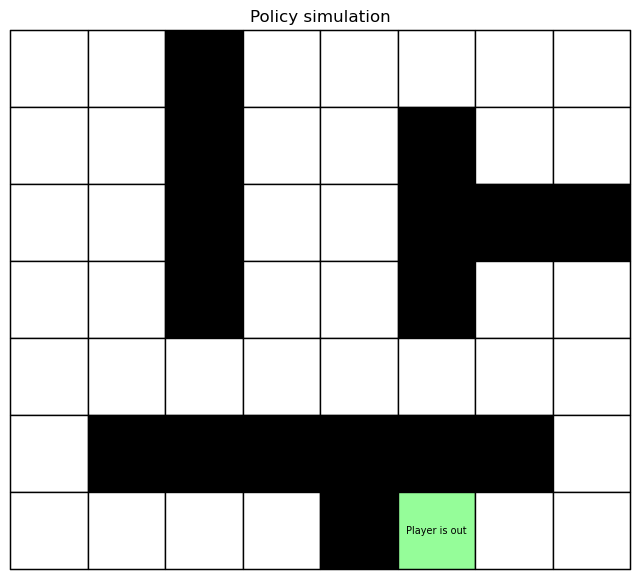

In [48]:
# Show the shortest path 
mz.animate_solution(maze, path)

### Point B: Value Iteration

In [52]:
# Create an environment maze
reload(mz)
env = mz.Maze(maze)

In [53]:
# Discount Factor 
p = 29/30
# Accuracy threshold
epsilon = 0.0001
V, policy = mz.value_iteration(env, p, epsilon)

In [57]:
# Simulate the shortest path starting from position A
method = 'ValIter'
start  = ((0,0),(6,5))
death_count = 0
win_count = 0
other_count = 0
mean_time = 0
iter = 10000
for i in range(iter):
    path = env.simulate(start, policy, method)
    #print(path)
    for t in range(len(path)):
        if path[t][0] == path[t][1]:
            death_count += 1
            break
        elif path[t][0] == (6,5):
            win_count += 1
            mean_time += t
            break
        elif t == len(path)-1:
            other_count += 1
            break

# mean_time = mean_time/win_count
print("Death for minotaur perc: " + str(death_count*(100/iter)) + "%")
print("Win perc: " + str(win_count*(100/iter)) + "%")
print("Death for the time perc: " + str(other_count*(100/iter)) + "%")
# print("Mean time: " + str(mean_time) + " steps")

Death perc: 0.0%
Win perc: 62.17%
Other perc: 37.83%


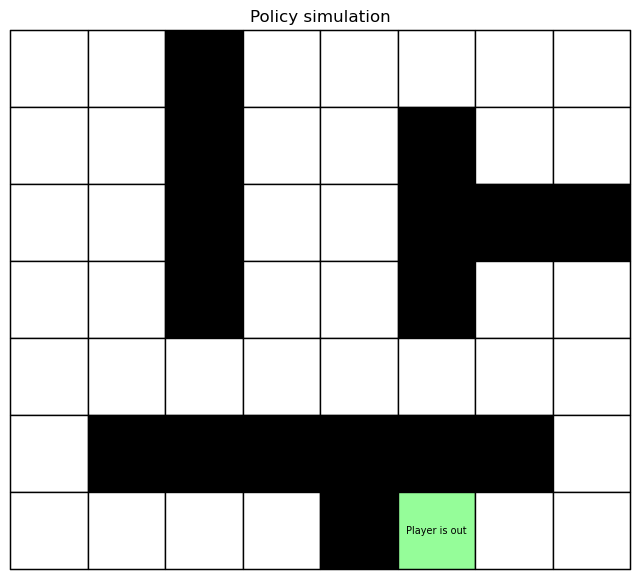

In [55]:
# Show the shortest path 
mz.animate_solution(maze, path)